In [19]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
import numpy as np

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

cpu



image 1/1 /home/dominiq/Desktop/MRO/LAB4/dog-cat.jpg: 480x640 1 car, 1 cat, 8 dogs, 1205.4ms
Speed: 6.0ms preprocess, 1205.4ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45:

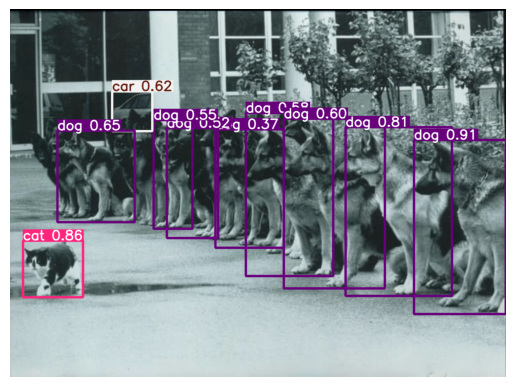

In [7]:
model = YOLO("yolov10m.pt")         # Load model weights 
model.to(device)                    # Force GPU Usage

results = model("./dog-cat.jpg")    # Perform prediction on image
print(results)                      # Print results

# Visualize image with bounding boxes and labels 
plt.imshow(results[0].plot())
plt.axis('off')
plt.show()

In [7]:
''' 
    For this task i will create datasets with:
        - 10000 images in train set 
        - 2000 images in test set 
        - 2000 images in validation set

'''

DATASET_SPLIT = {
    "train": 10000,
    "test": 2000,
    "validation": 2000
}

DATASET_IDS = {}

In [15]:
import pandas as pd
import os

def create_image_list(
    dataset_image_ids_path: str,  # Path to the CSV file with image IDs
    data_type: str,               # Type of dataset ('test', 'train', or 'validation')
    class_name: str               # Class name (e.g., 'Food', 'Animal', etc.)
):
    '''
        Create a list of image ID's based on specified class name. 
        
        
        Parameters:
        ---------------
        dataset_image_ids_path : str
            Path to the SCV file with list of images ID's 
            
        data_type : str
            Type of dataset for dataloader
            One of following: 
            - 'train'
            - 'test'
            - 'validation'
        
        class_name : str
            Name of class for which image list should be generated  

    '''
    
    # Columns of dataset
    column_names = ['ImageID','Source','LabelName','Confidence']
    class_descriptions = pd.read_csv(dataset_image_ids_path, names = column_names,  header=None, low_memory=False)
        
    # Filter collumns with given label name 
    filtered_images = class_descriptions[class_descriptions['LabelName'] == class_name]
    num_images_needed = DATASET_SPLIT.get(data_type, 0) 
    
    # Get ID's of extracted rows 
    filtered_images_ids = filtered_images['ImageID'].unique()[:num_images_needed]
    DATASET_IDS[data_type] = filtered_images_ids
    
    # Create list-file
    path = './image-lists/' + data_type + '_image.list.txt'

    with open(path, 'w') as f:
        for image_id in filtered_images_ids:
            f.write(f'{data_type}/{image_id}\n')
            
    print(f"{data_type} image list created! No. entities '{len(filtered_images_ids)}'\n")

In [16]:
# Retrieve food LabelName from class-descriptions
CATEGORY_NAME = "Food"
CLASS_DESCRIPTION_PATH = "./class-descriptions.csv"

column_names = ['LabelName', 'Category']
class_descriptions = pd.read_csv(CLASS_DESCRIPTION_PATH, names=column_names, header=None)
food_label_name = class_descriptions[class_descriptions["Category"] == CATEGORY_NAME]["LabelName"].iloc[0]

print(food_label_name)

/m/02wbm


In [17]:
file_categories = [
    ('test-annotations-human-imagelabels-boxable.csv', 'test'), 
    ('train-annotations-human-imagelabels-boxable.csv', 'train'),
    ('validation-annotations-human-imagelabels-boxable.csv', 'validation'),
]

for file, category in file_categories:
    path = f'./image-labels/{file}'
    create_image_list(path, category, food_label_name)

test image list created! No. entities '2000'

train image list created! No. entities '10000'

validation image list created! No. entities '2000'



In [15]:
!python .\downloader.py --num_processes 10 --download_folder .\dataset\images\validation ./ValidationData/image_list.txt
!python .\downloader.py --num_processes 10 --download_folder .\dataset\images\test ./TestData/image_list.txt
!python .\downloader.py --num_processes 10 --download_folder .\dataset\images\train ./TrainData/image_list.txt

^C


In [20]:
def create_labels_list(
    dataset_bbox_path: str,
    dataset: str,
    data_type: str,
    class_name: str,
    DATASET_IDS: dict
):
    # Columns to use
    use_columns = ['ImageID', 'LabelName', 'XMin', 'XMax', 'YMin', 'YMax']
    
    # Define the directory for saving the labels
    directory = f"./{dataset}/labels/{data_type}/"
    os.makedirs(directory, exist_ok=True)
    
    # Read the entire CSV file at once
    df = pd.read_csv(
        dataset_bbox_path,
        header=0,
        usecols=use_columns,
        engine='python',
        on_bad_lines='skip'
    )
    
    # Filter by class name and image ID
    mask = (
        (df['LabelName'] == class_name) &
        (df['ImageID'].isin(DATASET_IDS[data_type]))
    )
    filtered_df = df.loc[mask].copy()
    
    # Convert coordinates to numeric
    for col in ['XMin', 'XMax', 'YMin', 'YMax']:
        filtered_df[col] = pd.to_numeric(filtered_df[col], errors='coerce')
    
    # Calculate YOLO format coordinates
    filtered_df['width'] = filtered_df['XMax'] - filtered_df['XMin']
    filtered_df['height'] = filtered_df['YMax'] - filtered_df['YMin']
    filtered_df['center_x'] = (filtered_df['XMin'] + filtered_df['XMax']) / 2
    filtered_df['center_y'] = (filtered_df['YMin'] + filtered_df['YMax']) / 2
    
    # Process each filtered label
    for _, row in filtered_df.iterrows():
        file_path = os.path.join(directory, f"{row['ImageID']}.txt")
        with open(file_path, 'w') as f:
            f.write(f"0 {row['center_x']} {row['center_y']} {row['width']} {row['height']}\n")
    
    # Print a summary message
    total_labels = len(filtered_df)
    print(f"{data_type} bounding boxes created. No. entities '{total_labels}'\n")

In [20]:
def create_labels_list(
    dataset_bbox_path: str,
    dataset: str,
    data_type: str,
    class_name: str,
    DATASET_IDS: dict
):
    # Convert to set and numpy array for faster operations
    dataset_ids_set = set(DATASET_IDS[data_type])
    
    directory = f"./{dataset}/labels/{data_type}/"
    os.makedirs(directory, exist_ok=True)
    
    # Read data in chunks with optimized dtypes
    dtype_dict = {
        'ImageID': str,
        'LabelName': str,
        'XMin': np.float32,  # Using float32 instead of float64 for memory efficiency
        'XMax': np.float32,
        'YMin': np.float32,
        'YMax': np.float32
    }
    
    # Create a dictionary for faster lookup instead of using isin
    id_lookup = {id_: True for id_ in dataset_ids_set}
    
    chunks = []
    chunk_size = 1000000  # Adjust based on available RAM
    
    for chunk in pd.read_csv(
        dataset_bbox_path,
        usecols=dtype_dict.keys(),
        dtype=dtype_dict,
        engine='c',
        on_bad_lines='skip',
        chunksize=chunk_size
    ):
        # Fast filtering using numpy and dictionary lookup
        label_mask = chunk['LabelName'].values == class_name
        if label_mask.any():
            valid_chunk = chunk[label_mask]
            # Use vectorized dictionary lookup
            id_mask = np.vectorize(lambda x: id_lookup.get(x, False))(valid_chunk['ImageID'].values)
            chunks.append(valid_chunk[id_mask])
    
    if not chunks:
        print(f"No matching data found for {data_type}")
        return
    
    filtered_df = pd.concat(chunks, ignore_index=True)
    
    # Process all coordinates at once using numpy operations
    coords = filtered_df[['XMin', 'XMax', 'YMin', 'YMax']].values
    
    # Calculate YOLO format coordinates (all at once)
    yolo_coords = np.column_stack([
        np.zeros(len(coords)),  # class index (0)
        (coords[:, 0] + coords[:, 1]) / 2,  # center_x
        (coords[:, 2] + coords[:, 3]) / 2,  # center_y
        coords[:, 1] - coords[:, 0],  # width
        coords[:, 3] - coords[:, 2]   # height
    ])
    
    # Group by ImageID efficiently
    image_ids = filtered_df['ImageID'].values
    unique_ids, inverse_indices, counts = np.unique(image_ids, return_inverse=True, return_counts=True)
    
    # Write files in batches
    from concurrent.futures import ThreadPoolExecutor
    from itertools import groupby
    from operator import itemgetter
    
    def write_batch(batch_ids):
        for img_id in batch_ids:
            mask = image_ids == img_id
            file_path = os.path.join(directory, f"{img_id}.txt")
            # Use numpy's fast file writing
            np.savetxt(file_path, yolo_coords[mask], fmt=['%d', '%.6f', '%.6f', '%.6f', '%.6f'])
    
    # Process files in parallel
    batch_size = 1000  # Adjust based on your system
    with ThreadPoolExecutor(max_workers=8) as executor:  # Adjust max_workers based on your CPU
        batches = [unique_ids[i:i + batch_size] for i in range(0, len(unique_ids), batch_size)]
        executor.map(write_batch, batches)
    
    print(f"{data_type} bounding boxes created. No. entities '{len(filtered_df)}'\n")

In [21]:
annotation_categories = [
    ('test-annotations-bbox.csv', 'test'), 
    ('train-annotations-bbox.csv', 'train'),
    ('validation-annotations-bbox.csv', 'validation'),
]

DATASET = 'dataset'

for file, category in annotation_categories:
    path = f'./image-annotation/{file}'
    create_labels_list(path, DATASET, category, food_label_name, DATASET_IDS)

test bounding boxes created. No. entities '1413'

train bounding boxes created. No. entities '4443'

validation bounding boxes created. No. entities '1581'



"create_labels_list(\n    './TestData/test-annotations-bbox.csv',\n    'test', \n    food_label_name,\n    DATASET_IDS\n)\n\ncreate_labels_list(\n    './TrainData/oidv6-train-annotations-bbox.csv',\n    'train', \n    food_label_name,\n    DATASET_IDS\n)\n\ncreate_labels_list(\n    './ValidationData/validation-annotations-bbox.csv',\n    'validation', \n    food_label_name,\n    DATASET_IDS\n)"

In [ ]:
import torch
from torch.utils.tensorboard import SummaryWriter
from tensorboard import notebook

In [22]:
%load_ext tensorboard
%tensorboard --logdir runs/train


Launching TensorBoard...

In [26]:
# from ultralytics import YOLO

model = YOLO("yolov8n.pt")         # Load model weights 

results = model.train(
    data='./data.yaml',       
    epochs=5,              
    project='runs/train',   
    name='yolo8',  
    batch = 16,
    device=device,        
    single_cls=True,       
    amp =False,
    plots=True               
)


engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=./data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=runs/train, name=yolo84, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimize=False, int8=False, dynamic

train: Scanning /home/dominiq/Desktop/MRO/LAB4/dataset/labels/train.cache... 1349 images, 8651 backgrounds, 0 corrupt: 100%|██████████| 10000/10000 [00:00<?, ?it/s]
val: Scanning /home/dominiq/Desktop/MRO/LAB4/dataset/labels/train.cache... 1349 images, 8651 backgrounds, 0 corrupt: 100%|██████████| 10000/10000 [00:00<?, ?it/s]

Plotting labels to runs/train/yolo84/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/train/yolo84
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      1.366      5.577      1.468         38        640:  16%|█▌        | 97/625 [14:50<1:20:46,  9.18s/it]


KeyboardInterrupt: 


image 1/1 /home/dominiq/Desktop/MRO/LAB4/0ac1717140554997.jpg: 480x640 1 food, 98.9ms
Speed: 2.1ms preprocess, 98.9ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


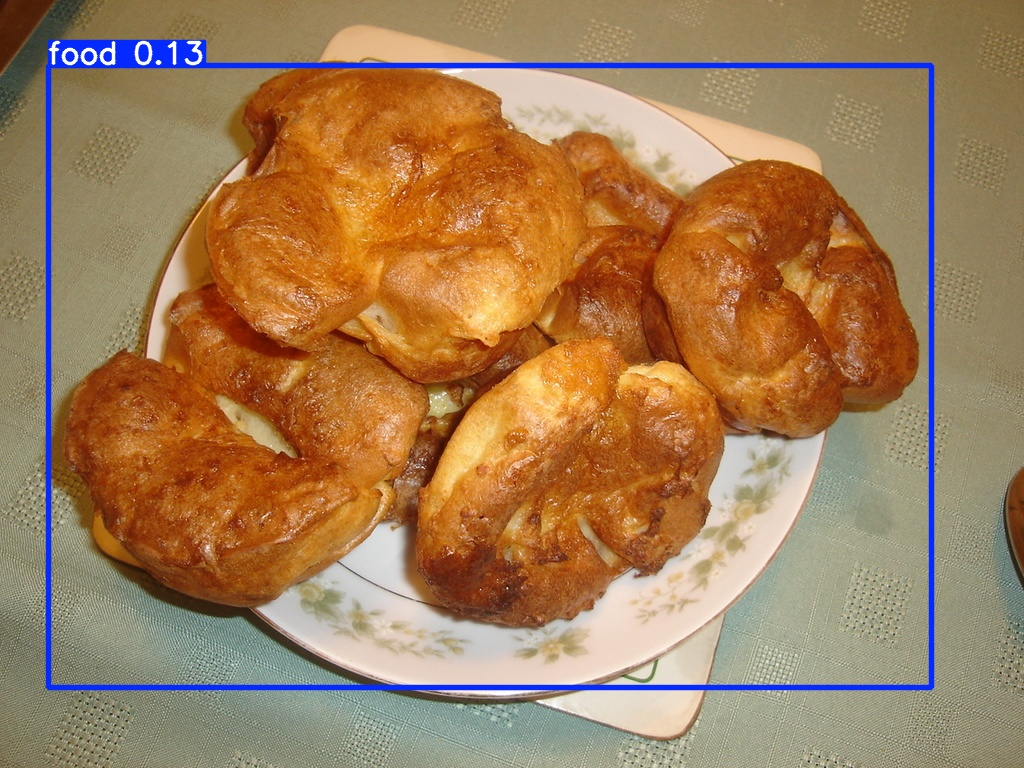

In [89]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model
model = YOLO("/home/dominiq/Desktop/MRO/LAB4/runs/train/yolo8-next/weights/last.pt")
model.to(device)                    # Force GPU Usage

results = model.predict("./0ac1717140554997.jpg", conf=0.03)    # Perform prediction on image
# Get the annotated image (as a numpy array)
annotated_image = results[0].plot()

# Save the numpy array as an image
cv2.imwrite("annotated_image.jpg", annotated_image)

# Display the saved image
display(Image("annotated_image.jpg"))


image 1/1 /home/dominiq/Desktop/MRO/LAB4/0ac1717140554997.jpg: 480x640 1 food, 101.1ms
Speed: 2.4ms preprocess, 101.1ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


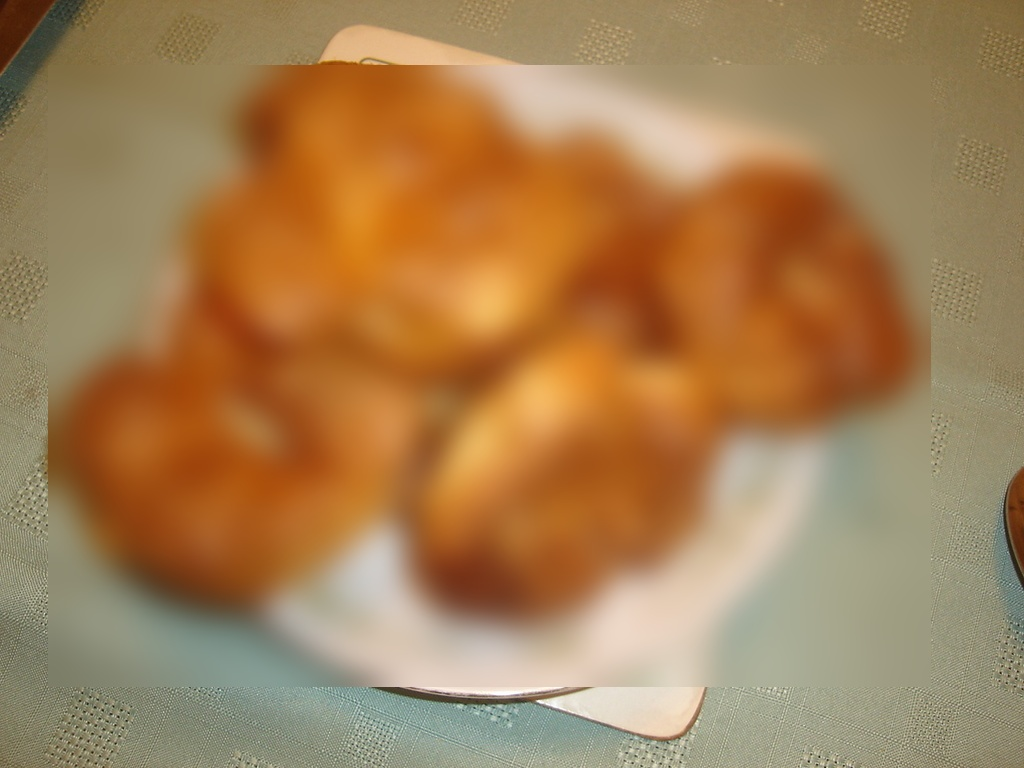

In [90]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model
model = YOLO("/home/dominiq/Desktop/MRO/LAB4/runs/train/yolo8-next/weights/last.pt")
model.to(device)

def blur_image(
   model: YOLO,
   image: str,
   conf: int
):
   results = model.predict(image, conf=conf)

   image_arr = cv2.imread(image)
   for result in results:
       for box in result.boxes:
           x1, y1, x2, y2 = map(int, box.xyxy[0])
           roi = image_arr[y1:y2, x1:x2]
           image_arr[y1:y2, x1:x2] = cv2.GaussianBlur(roi, (99, 99), 0)
   
   filename = image.rsplit('.', 1)[0]
   output_path = f"{filename}_blurred.jpg"
   
   cv2.imwrite(output_path, image_arr)
   display(Image(output_path))

image_path = '0ac1717140554997.jpg'
blur_image(model, image_path, 0.03)



image 1/1 /home/dominiq/Desktop/MRO/LAB4/000c5f3f0b58ce18.jpg: 480x640 2 foods, 254.9ms
Speed: 24.5ms preprocess, 254.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


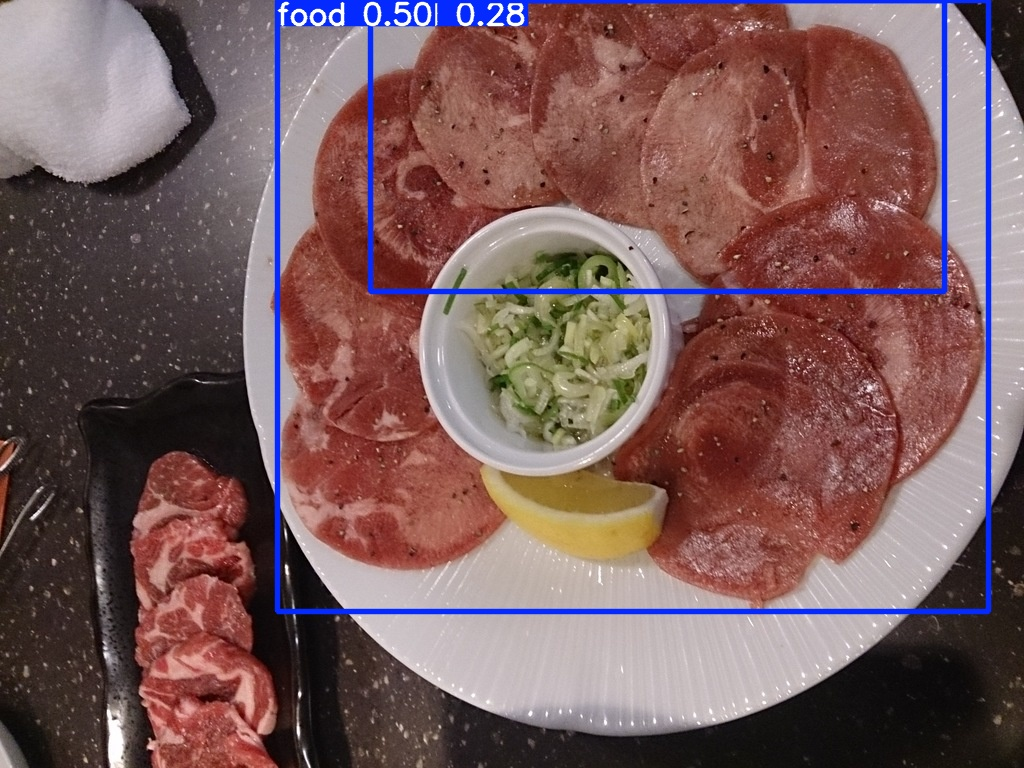

In [34]:
import cv2
from IPython.display import Image, display

model = YOLO("best.pt")             # Load model weights 
model.to(device)                    # Force GPU Usage

results = model("./000c5f3f0b58ce18.jpg")    # Perform prediction on image
# Get the annotated image (as a numpy array)
annotated_image = results[0].plot()

# Save the numpy array as an image
cv2.imwrite("annotated_image.jpg", annotated_image)

# Display the saved image
display(Image("annotated_image.jpg"))

In [72]:
# Load an image
image_path = '15077497161532b3.jpg'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Run inference
results = model(image_rgb)

detections = results.pandas().xyxy[0]
detection_list = detections.to_dict(orient='records')

def blur_region(image, x1, y1, x2, y2, ksize=(15, 15)):
    roi = image[y1:y2, x1:x2]
    blurred_roi = cv2.GaussianBlur(roi, ksize, 0)
    image[y1:y2, x1:x2] = blurred_roi
    return image

for detection in detection_list:
    x1, y1, x2, y2 = int(detection['xmin']), int(detection['ymin']), int(detection['xmax']), int(detection['ymax'])
    image_rgb = blur_region(image_rgb, x1, y1, x2, y2)

plt.figure(figsize=(10, 5))
plt.imshow(image_rgb)
plt.title("Blurred Detected Objects")
plt.axis('off')
plt.show()



0: 544x640 (no detections), 236.2ms
Speed: 5.0ms preprocess, 236.2ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


AttributeError: 'list' object has no attribute 'pandas'

In [74]:

def blur_region(image, x1, y1, x2, y2, ksize=(15, 15)):
    """Apply Gaussian blur to a specific region of the image."""
    # Ensure coordinates are within image bounds
    h, w = image.shape[:2]
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(w, x2), min(h, y2)
    
    # Extract and blur ROI
    roi = image[y1:y2, x1:x2]
    if roi.size > 0:  # Check if ROI is not empty
        blurred_roi = cv2.GaussianBlur(roi, ksize, 0)
        image[y1:y2, x1:x2] = blurred_roi
    return image

def process_image_with_blur(image_path, model, conf_threshold=0.0015, blur_size=(15, 15)):
    """Process image with YOLOv8 and apply blur to detections."""
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not load image from {image_path}")
    
    # Convert to RGB for YOLOv8
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Run inference
    results = model(image_rgb, conf=conf_threshold)
    
    # Create a copy for modification
    output_image = image_rgb.copy()
    
    # Process each detection
    for result in results:
        boxes = result.boxes
        for box in boxes:
            # Get coordinates
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            
            # Apply blur
            output_image = blur_region(output_image, x1, y1, x2, y2, blur_size)
    
    return output_image

def visualize_results(original_image, processed_image, figsize=(15, 7)):
    """Display original and processed images side by side."""
    plt.figure(figsize=figsize)
    
    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')
    
    # Processed image
    plt.subplot(1, 2, 2)
    plt.imshow(processed_image)
    plt.title("Image with Blurred Detections")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


image_path = '15077497161532b3.jpg'
    
    # Load original image for comparison
original_image = cv2.imread(image_path)

# Process image and apply blur
processed_image = process_image_with_blur(
    image_path=image_path,
    model=model,
    conf_threshold=0.25,  # Adjust confidence threshold as needed
    blur_size=(15, 15)    # Adjust blur intensity as needed
)

# Visualize results
visualize_results(original_image, processed_image)

# Optionally save the result
output_path = 'output_blurred.jpg'
plt.imsave(output_path, processed_image)

0: 544x640 (no detections), 237.3ms
Speed: 5.6ms preprocess, 237.3ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)


<Figure size 1500x700 with 2 Axes>